In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from scipy.stats import stats
from IPython.display import display
import pymc3 as pm
import statsmodels.api as sm
import theano.tensor as tt
import seaborn as sns
import arviz as az

%matplotlib inline

cwd = os.getcwd()

In [2]:
# read in the overall aggregated dataset on hour,day,month and year
df = pd.read_csv(
                os.path.join("Citibike_Aggregate",
                 "GroupBy_Year_Month_Day_Hour_Seconds_Distance.csv"))
df.head()

,Start Year,Start Month,Start Day,Start Hour,Duration_Seconds_SUM,Duration_Seconds_COUNT,Station_Distance_SUM,Station_Distance_COUNT
0,2017,1,1,0,654326,706,1320474,706
1,2017,1,1,1,519550,704,1084164,704
2,2017,1,1,2,543026,564,1000274,564
3,2017,1,1,3,290928,414,614700,414
4,2017,1,1,4,567570,192,273208,192


# Aggregate Statistics Plot

- check count of bike trips
- check duration of bike trips
- check distance of bike trips

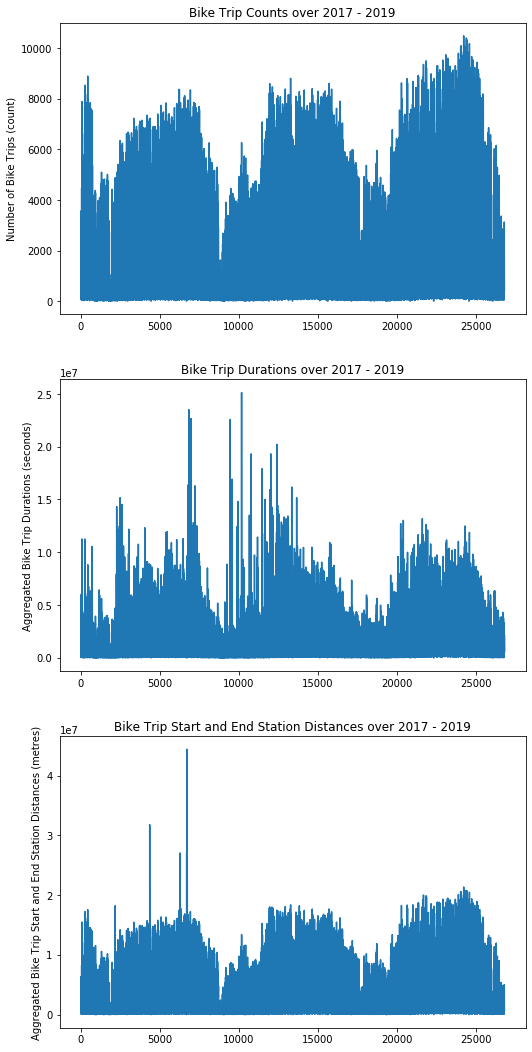

In [3]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.5,15))

axes[0].plot(df["Duration_Seconds_COUNT"])
axes[0].set_title("Bike Trip Counts over 2017 - 2019")
axes[0].set_ylabel("Number of Bike Trips (count)")

axes[1].plot(df["Duration_Seconds_SUM"])
axes[1].set_title("Bike Trip Durations over 2017 - 2019")
axes[1].set_ylabel("Aggregated Bike Trip Durations (seconds)")

axes[2].plot(df["Station_Distance_SUM"])
axes[2].set_title("Bike Trip Start and End Station Distances over 2017 - 2019")
axes[2].set_ylabel("Aggregated Bike Trip Start and End Station Distances (metres)")

plt.tight_layout()
fig.savefig(os.path.join("images", "pymc3", "Summarized Plot for Count, Duration and Distance.png"));

# Aggregate Statistics Histogram

- check count of bike trips
- check duration of bike trips
- check distance of bike trips

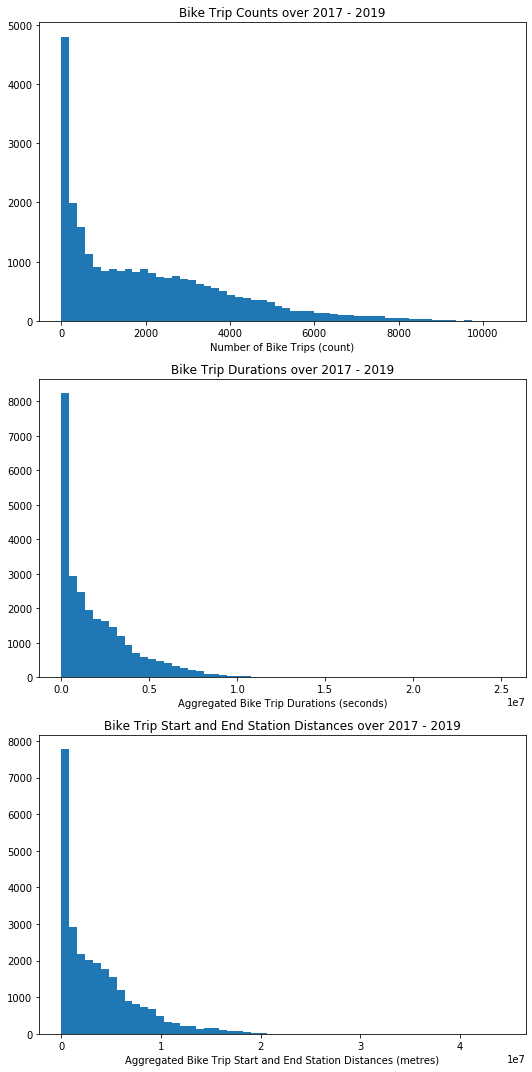

In [4]:
# lets get the histograms instead

# use Freedman–Diaconis rule for bin width then calculate number of bins from there
iqr = stats.iqr(df["Duration_Seconds_COUNT"].values)
n = len(df["Duration_Seconds_COUNT"].values)
bins = (np.max(df["Duration_Seconds_COUNT"].values) - np.min(df["Duration_Seconds_COUNT"].values)) / (2 * iqr / np.cbrt(n))

# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7.5,15))

axes[0].hist(df["Duration_Seconds_COUNT"], bins=int(bins)+1)
axes[0].set_title("Bike Trip Counts over 2017 - 2019")
axes[0].set_xlabel("Number of Bike Trips (count)")

axes[1].hist(df["Duration_Seconds_SUM"], bins=int(bins)+1)
axes[1].set_title("Bike Trip Durations over 2017 - 2019")
axes[1].set_xlabel("Aggregated Bike Trip Durations (seconds)")

axes[2].hist(df["Station_Distance_SUM"], bins=int(bins)+1)
axes[2].set_title("Bike Trip Start and End Station Distances over 2017 - 2019")
axes[2].set_xlabel("Aggregated Bike Trip Start and End Station Distances (metres)")

plt.tight_layout()
fig.savefig(os.path.join("images", "pymc3", "Summarized Histogram for Count, Duration and Distance.png"));

# Aggregate Statistics Count Model

- Count of Bike Trips is modelled by Exponential

In [5]:
# returns is now going to be a percentage of the max
count_max = df["Duration_Seconds_COUNT"].max()

returns = (df["Duration_Seconds_COUNT"] / count_max).values
returns

array([0.06729578, 0.06710514, 0.05376037, ..., 0.05290249, 0.05337909,
       0.04012963])

In [6]:
with pm.Model() as model1:
    # Prior
    lam = pm.Uniform("lam", lower=1, upper=1000)
    
    # likelihood
    likelihood = pm.Exponential("likelihood", lam=lam,
                               observed=returns)
    # Posterior
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10_000, chains=3, step=step, start=start,
                      progressbar=True, cores=3)
    burned_trace = trace[5_000::10]
    
    # sample posterior
    posterior_checks = pm.sample_posterior_predictive(burned_trace, samples=500, random_seed=42)

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [lam]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 39 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\danie\anaconda3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [7]:
burned_trace.varnames

['lam_interval__', 'lam']

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


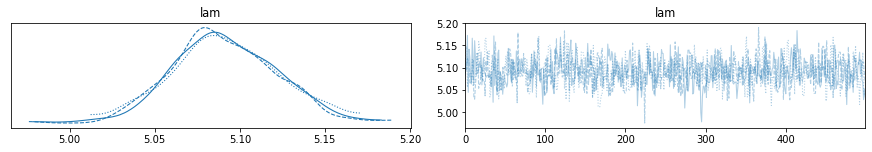

In [8]:
pm.traceplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Traceplot for normalized Total Counts.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


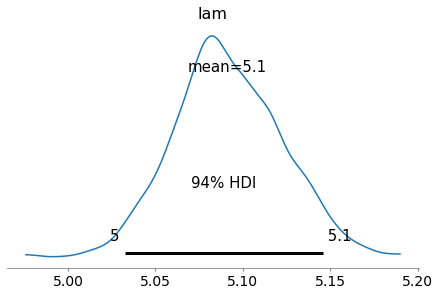

In [9]:
pm.plot_posterior(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Posterior Plot for normalized Total Counts.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


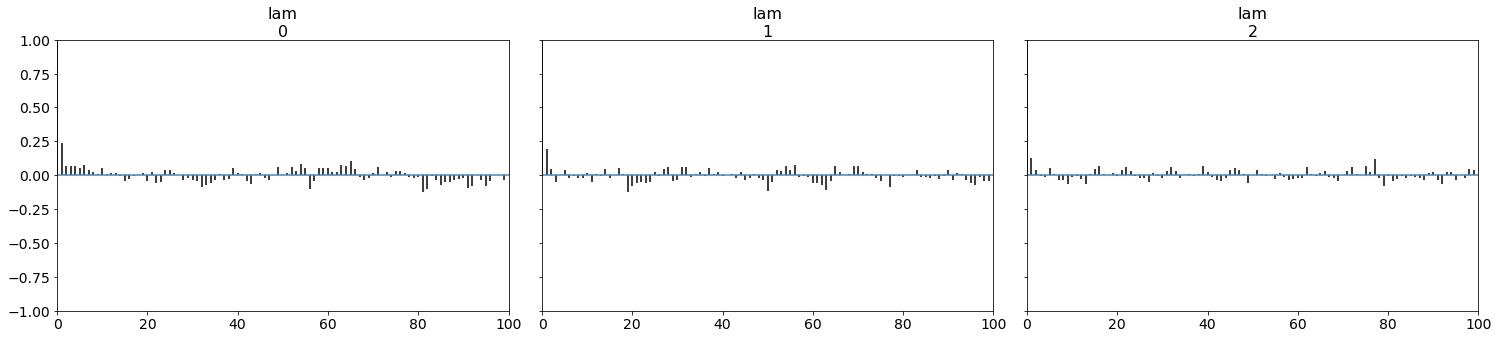

In [10]:
pm.autocorrplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Autocorrelation for normalized Total Counts.png"));

In [11]:
summary = pm.summary(burned_trace)
summary

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam,5.091,0.031,5.032,5.146,0.001,0.001,945.0,945.0,939.0,886.0,1.0


In [12]:
print(summary.to_markdown())

|     |   mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_mean |   ess_sd |   ess_bulk |   ess_tail |   r_hat |
|:----|-------:|------:|---------:|----------:|------------:|----------:|-----------:|---------:|-----------:|-----------:|--------:|
| lam |  5.091 | 0.031 |    5.032 |     5.146 |       0.001 |     0.001 |        945 |      945 |        939 |        886 |       1 |


In [13]:
# generate the prior and posterior distributions from the mean of 500 draws (also grab standard deviation)
posterior_likelihood = posterior_checks["likelihood"].mean(axis=0)
posterior_likelihood_std = posterior_checks["likelihood"].std(axis=0)

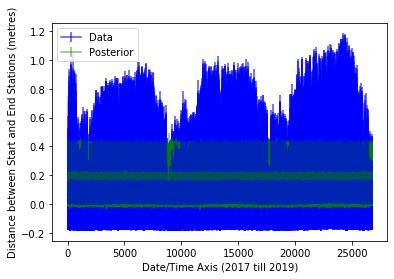

In [14]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.errorbar(x=np.arange(len(posterior_likelihood)),
         y=posterior_likelihood, yerr=posterior_likelihood_std, color="green", alpha=0.5, label="Posterior")
plt.ylabel("Distance between Start and End Stations (metres)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Posterior for normalized Total Counts.png"));

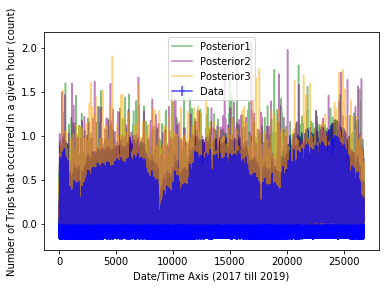

In [15]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.plot(np.arange(len(posterior_checks["likelihood"][0])),
         posterior_checks["likelihood"][0], color="green", alpha=0.5, label="Posterior1")
plt.plot(np.arange(len(posterior_checks["likelihood"][1])),
         posterior_checks["likelihood"][1], color="purple", alpha=0.5, label="Posterior2")
plt.plot(np.arange(len(posterior_checks["likelihood"][2])),
         posterior_checks["likelihood"][2], color="orange", alpha=0.5, label="Posterior3")
plt.ylabel("Number of Trips that occurred in a given hour (count)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Individual Posterior for normalized Total Counts.png"));

# Aggregate Statistics Duration Model

- Duration of Bike Trips is modelled by Exponential

In [16]:
# returns is now going to be a percentage of the max
duration_max = df["Duration_Seconds_SUM"].max()

returns = (df["Duration_Seconds_SUM"] / duration_max).values
returns

array([0.02604108, 0.02067722, 0.02161153, ..., 0.08531775, 0.01973022,
       0.02747756])

In [17]:
with pm.Model() as model2:
    # Prior
    lam = pm.Uniform("lam", lower=1, upper=1000)
    
    # likelihood
    likelihood = pm.Exponential("likelihood", lam=lam,
                               observed=returns)
    # Posterior
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10_000, chains=3, step=step, start=start,
                      progressbar=True, cores=3)
    burned_trace = trace[5_000::10]
    
    # sample posterior
    posterior_checks = pm.sample_posterior_predictive(burned_trace, samples=500, random_seed=42)

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [lam]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 36 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\danie\anaconda3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [18]:
burned_trace.varnames

['lam_interval__', 'lam']

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


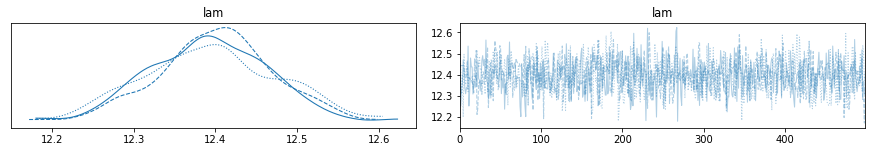

In [19]:
pm.traceplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Traceplot for normalized Total Duration.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


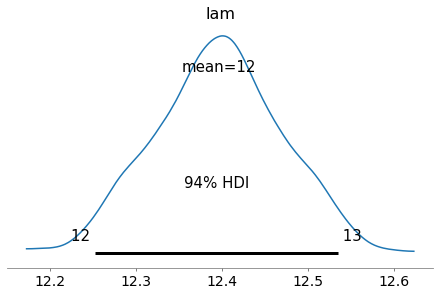

In [20]:
pm.plot_posterior(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Posterior Plot for normalized Total Duration.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


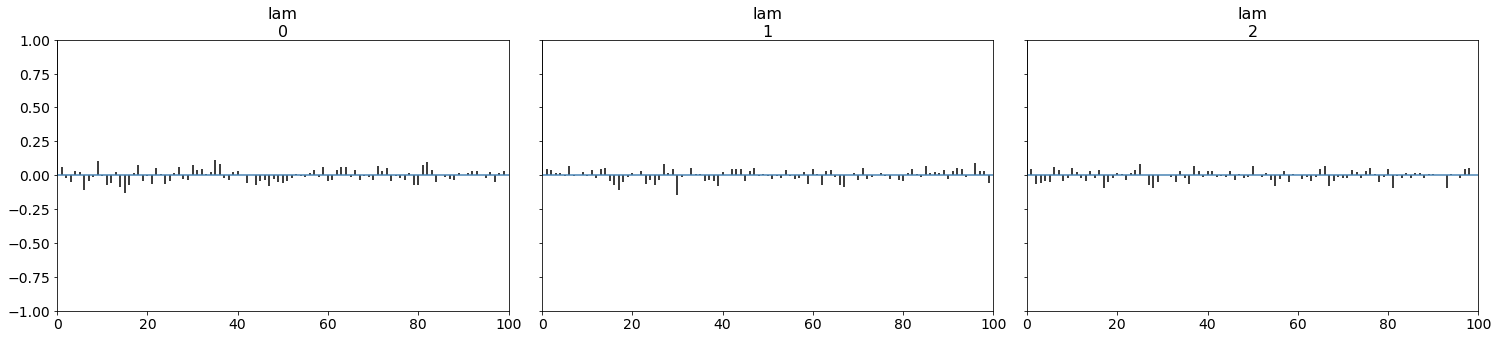

In [21]:
pm.autocorrplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Autocorrelation for normalized Total Duration.png"));

In [22]:
summary = pm.summary(burned_trace)
summary

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam,12.396,0.076,12.252,12.534,0.002,0.001,1360.0,1360.0,1356.0,813.0,1.01


In [23]:
print(summary.to_markdown())

|     |   mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_mean |   ess_sd |   ess_bulk |   ess_tail |   r_hat |
|:----|-------:|------:|---------:|----------:|------------:|----------:|-----------:|---------:|-----------:|-----------:|--------:|
| lam | 12.396 | 0.076 |   12.252 |    12.534 |       0.002 |     0.001 |       1360 |     1360 |       1356 |        813 |    1.01 |


In [24]:
# generate the prior and posterior distributions from the mean of 500 draws (also grab standard deviation)
posterior_likelihood = posterior_checks["likelihood"].mean(axis=0)
posterior_likelihood_std = posterior_checks["likelihood"].std(axis=0)

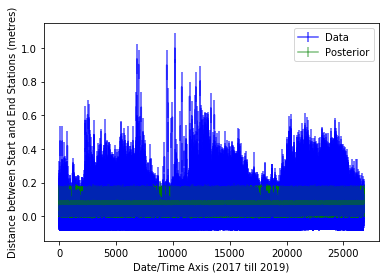

In [25]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.errorbar(x=np.arange(len(posterior_likelihood)),
         y=posterior_likelihood, yerr=posterior_likelihood_std, color="green", alpha=0.5, label="Posterior")
plt.ylabel("Distance between Start and End Stations (metres)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Posterior for normalized Total Duration.png"));

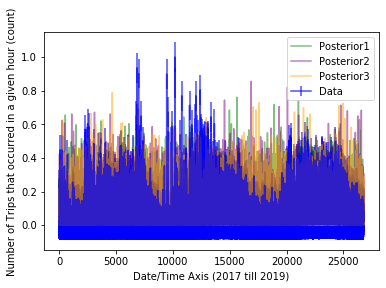

In [26]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.plot(np.arange(len(posterior_checks["likelihood"][0])),
         posterior_checks["likelihood"][0], color="green", alpha=0.5, label="Posterior1")
plt.plot(np.arange(len(posterior_checks["likelihood"][1])),
         posterior_checks["likelihood"][1], color="purple", alpha=0.5, label="Posterior2")
plt.plot(np.arange(len(posterior_checks["likelihood"][2])),
         posterior_checks["likelihood"][2], color="orange", alpha=0.5, label="Posterior3")
plt.ylabel("Number of Trips that occurred in a given hour (count)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Individual Posterior for normalized Total Duration.png"));

# Aggregate Statistics Distance Model

- Distance of Bike Trips is modelled by Exponential

In [27]:
# returns is now going to be a percentage of the max
distance_max = df["Station_Distance_SUM"].max()

returns = (df["Station_Distance_SUM"] / distance_max).values
returns

array([0.02973378, 0.02441267, 0.02252367, ..., 0.02018503, 0.0200002 ,
       0.01502312])

In [28]:
with pm.Model() as model3:
    # Prior
    lam = pm.Uniform("lam", lower=1, upper=1000)
    
    # likelihood
    likelihood = pm.Exponential("likelihood", lam=lam,
                               observed=returns)
    # Posterior
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10_000, chains=3, step=step, start=start,
                      progressbar=True, cores=3)
    burned_trace = trace[5_000::10]
    
    # sample posterior
    posterior_checks = pm.sample_posterior_predictive(burned_trace, samples=500, random_seed=42)

Multiprocess sampling (3 chains in 3 jobs)
Metropolis: [lam]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 35 seconds.
The number of effective samples is smaller than 25% for some parameters.
C:\Users\danie\anaconda3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [29]:
burned_trace.varnames

['lam_interval__', 'lam']

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


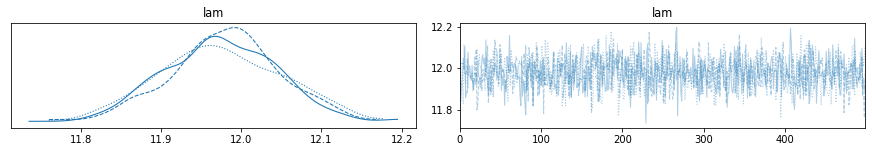

In [30]:
pm.traceplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Traceplot for normalized Total Distance.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


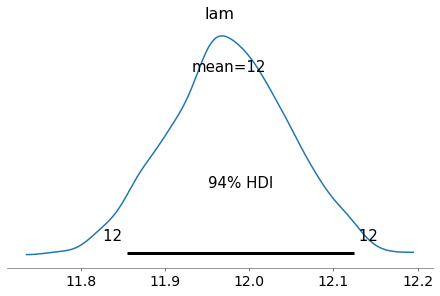

In [31]:
pm.plot_posterior(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Posterior Plot for normalized Total Distance.png"));

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


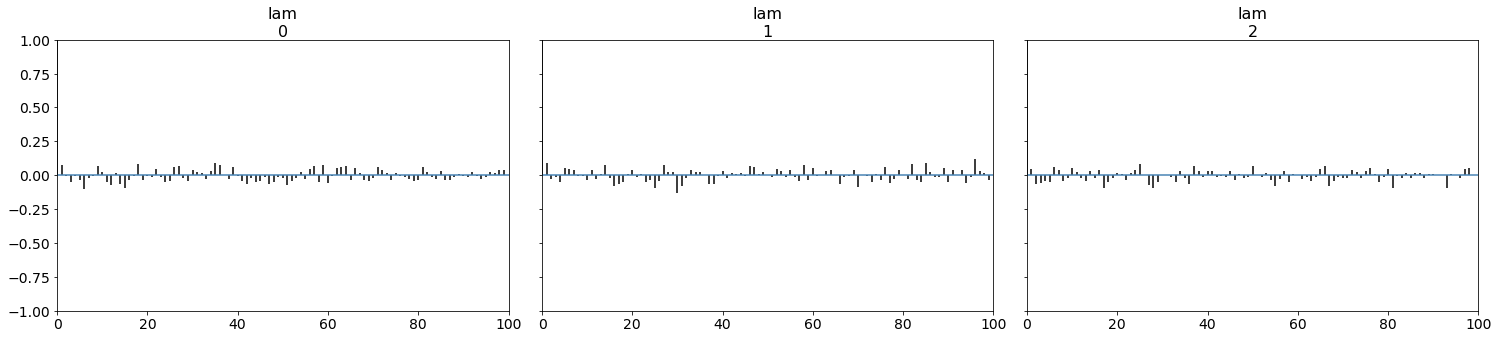

In [32]:
pm.autocorrplot(burned_trace)
plt.savefig(os.path.join("images", "pymc3", "Autocorrelation for normalized Total Distance.png"));

In [33]:
summary = pm.summary(burned_trace)
summary

C:\Users\danie\anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam,11.976,0.073,11.854,12.125,0.002,0.001,1310.0,1310.0,1304.0,1196.0,1.0


In [34]:
print(summary.to_markdown())

|     |   mean |    sd |   hdi_3% |   hdi_97% |   mcse_mean |   mcse_sd |   ess_mean |   ess_sd |   ess_bulk |   ess_tail |   r_hat |
|:----|-------:|------:|---------:|----------:|------------:|----------:|-----------:|---------:|-----------:|-----------:|--------:|
| lam | 11.976 | 0.073 |   11.854 |    12.125 |       0.002 |     0.001 |       1310 |     1310 |       1304 |       1196 |       1 |


In [35]:
# generate the prior and posterior distributions from the mean of 500 draws (also grab standard deviation)
posterior_likelihood = posterior_checks["likelihood"].mean(axis=0)
posterior_likelihood_std = posterior_checks["likelihood"].std(axis=0)

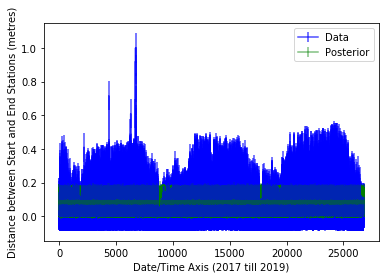

In [36]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.errorbar(x=np.arange(len(posterior_likelihood)),
         y=posterior_likelihood, yerr=posterior_likelihood_std, color="green", alpha=0.5, label="Posterior")
plt.ylabel("Distance between Start and End Stations (metres)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Posterior for normalized Total Distance.png"));

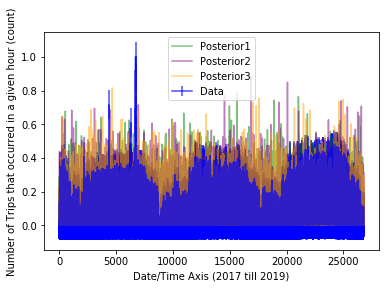

In [37]:
# use matplotlib plottng to plot returns, prior and posterior distributions

plt.errorbar(x=np.arange(len(returns)), y=returns, yerr=returns.std(), color="blue", alpha=0.7, label="Data")
plt.plot(np.arange(len(posterior_checks["likelihood"][0])),
         posterior_checks["likelihood"][0], color="green", alpha=0.5, label="Posterior1")
plt.plot(np.arange(len(posterior_checks["likelihood"][1])),
         posterior_checks["likelihood"][1], color="purple", alpha=0.5, label="Posterior2")
plt.plot(np.arange(len(posterior_checks["likelihood"][2])),
         posterior_checks["likelihood"][2], color="orange", alpha=0.5, label="Posterior3")
plt.ylabel("Number of Trips that occurred in a given hour (count)")
plt.xlabel("Date/Time Axis (2017 till 2019)")
plt.legend()
plt.savefig(os.path.join("images", "pymc3", "Data and Individual Posterior for normalized Total Distance.png"));